### Backtesting.py kasutamine ja erinevad harjutused
#### https://kernc.github.io/backtesting.py/  

In [45]:
pip install backtesting

Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
#to import talib
from backtesting import Backtest, Strategy
#from backtesting.test import GOOG
import yfinance as yf
import pandas as pd
from backtesting.lib import crossover, plot_heatmaps, resample_apply, barssince
import talib
import seaborn as sns

In [48]:
#import symbol
symbols = ["KO"] 
df_multiple_symbols = yf.download(symbols, start="2009-01-01", end="2024-01-01")

[*********************100%***********************]  1 of 1 completed


In [49]:
df_multiple_symbols

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,22.700001,23.000000,22.520000,22.950001,14.269992,16355800
2009-01-05,22.785000,22.945000,22.590000,22.719999,14.126978,20237200
2009-01-06,22.850000,22.985001,22.230000,22.355000,13.900030,21307800
2009-01-07,22.110001,22.590000,22.110001,22.465000,13.968426,21581000
2009-01-08,22.420000,22.639999,22.280001,22.620001,14.064808,20087000
...,...,...,...,...,...,...
2023-12-22,58.119999,58.459999,58.020000,58.320000,57.857216,9028500
2023-12-26,58.060001,58.709999,58.060001,58.560001,58.095314,6422500
2023-12-27,58.639999,58.770000,58.400002,58.709999,58.244122,8560100


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

upper_bound  lower_bound  rsi_window
50           5            2             0.368501
             10           2             0.038861
             15           2             0.240463
             20           2             0.255956
             25           2             0.411504
                                          ...   
85           25           2             0.520502
             30           2             0.622391
             35           2             0.587486
             40           2             0.555102
             45           2             0.543104
Name: Sharpe Ratio, Length: 72, dtype: float64
Start                     2009-01-02 00:00:00
End                       2023-12-29 00:00:00
Duration                   5474 days 00:00:00
Exposure Time [%]                   20.826709
Equity Final [$]                 24670.561176
Equity Peak [$]                  29092.410355
Return [%]                         146.705612
Buy & Hold Return [%]              156.775592
Return (A

/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p7015', ...)

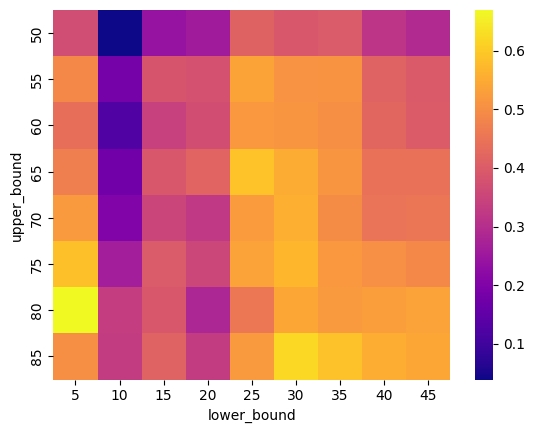

In [50]:
def optim_func(series):

#   filters out precondition 
    if series['Win Rate [%]'] < 75:
        return -1

    return series ['# Trades'] * series ['Return (Ann.) [%]'] 

class RsiOscillator(Strategy):
    
    upper_bound=80
    lower_bound=20
    rsi_window = 14
#    ema_window = 233
    
    #Rsi input from talib
    def init (self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)
#        self.ema = self.I(talib.EMA, self.data.Close, self.ema_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi): #and self.data.Close > self.ema:
            self.buy()

bt = Backtest(df_multiple_symbols, RsiOscillator, cash=10000)

#stats = bt.run()
stats, heatmap = bt.optimize(
    upper_bound = range(50, 90, 5),
    lower_bound = range(5, 50, 5),
    rsi_window = 2,
    #maximize towards
    maximize = "Sharpe Ratio",
    constraint = lambda param: param.upper_bound > param.lower_bound,
    return_heatmap = True
    #max_tries = 100
    )

#lower_bound = stats["_strategy"].lower_bound
print(heatmap)
hm = heatmap.groupby(["upper_bound", "lower_bound"]).mean().unstack()
#print(hm)
print(stats)
sns.heatmap(hm, cmap="plasma")
lower_bound = stats["_strategy"].lower_bound
upper_bound = stats["_strategy"].upper_bound
rsi_window = stats["_strategy"].rsi_window
bt.plot()

In [51]:
#Using Rsi 2-3 testing with Exponential Moving Average of 233 as the long filter
def optim_func(series):

#   filters out precondition winrate vähem kui 70%,max drawdown väiksem kui -30 ja trades vähem kui 150
    if series["Win Rate [%]"] < 70 or series['Max. Drawdown [%]'] < -30 or series ["# Trades"] < 150:
        return -1
    return series ["Win Rate [%]"] * series ["Return (Ann.) [%]"] 
class RsiOscillator(Strategy):
    
    upper_bound=80
    lower_bound=20
    rsi_window = 14
    ema_window = 233

    def init (self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)
        self.ema = self.I(talib.EMA, self.data.Close, self.ema_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi) and self.data.Close > self.ema:
            self.buy()

bt = Backtest(df_multiple_symbols, RsiOscillator, cash=10000)

#stats = bt.run()
#add heatmap next to stats if you want it
stats, heatmap = bt.optimize(
    upper_bound = range(50, 90, 5),
    lower_bound = range(5, 50, 5),
    rsi_window = range(2, 4, 1),
    maximize = optim_func,
    constraint = lambda param: param.upper_bound > param.lower_bound,
    return_heatmap = True
    #max_tries = 100
    )

#lower_bound = stats["_strategy"].lower_bound
#print(heatmap)
#plot_heatmaps(heatmap, agg="mean")

print(stats)
lower_bound = stats["_strategy"].lower_bound
upper_bound = stats["_strategy"].upper_bound
rsi_window = stats["_strategy"].rsi_window
print(stats["_strategy"])

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

upper_bound  lower_bound  rsi_window
50           5            2            -1.0
                          3            -1.0
             10           2            -1.0
                          3            -1.0
             15           2            -1.0
                                       ... 
85           35           3            -1.0
             40           2            -1.0
                          3            -1.0
             45           2            -1.0
                          3            -1.0
Length: 144, dtype: float64
Start                     2009-01-02 00:00:00
End                       2023-12-29 00:00:00
Duration                   5474 days 00:00:00
Exposure Time [%]                    6.279809
Equity Final [$]                 12674.018808
Equity Peak [$]                  13314.809008
Return [%]                          26.740188
Buy & Hold Return [%]              156.775592
Return (Ann.) [%]                     1.59489
Volatility (Ann.) [%]                

In [52]:
bt.plot()

/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p7521', ...)

In [53]:
#Testing dow jones 30 stocks and picking best average indicator conditions
# Define the list of Dow Jones 30 stocks
dow_jones_30 = [
    "AAPL", "MSFT", "KO","PM", "MU", "BSX", "KLAC", "SO", "CL", "FCX", "TGT", "SLB", "PYPL", 
    "USB", "MMM", "WMB", "AEP", "KR", "FITB", "CNP"
]

# Function to optimize
def optim_func(series):
    if series["Win Rate [%]"] < 72 or series['# Trades'] < 130 or series['Max. Drawdown [%]'] < -25:
        return -1
    return series["Win Rate [%]"] * series["Return [%]"]

# Strategy class
class RsiOscillator(Strategy):
    upper_bound = 80
    lower_bound = 20
    rsi_window = 14


    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi) :
            self.buy()

# Function to run backtest for a single stock
def backtest_stock(symbol):
    df = yf.download(symbol, start="2010-01-01", end="2024-03-03")
    bt = Backtest(df, RsiOscillator, cash=10000)
    stats = bt.optimize(
        upper_bound=range(50, 90, 5),
        lower_bound=range(5, 50, 5),
        rsi_window=range(2, 5, 1),
        maximize=optim_func,
        constraint=lambda param: param.upper_bound > param.lower_bound
    )
    return stats

# Collect results for all stocks
results = []
optimal_params = []
for symbol in dow_jones_30:
    print(f"Running backtest for {symbol}")
    result = backtest_stock(symbol)
    results.append(result)
    optimal_params.append({
        'symbol': symbol,
        'lower_bound': result['_strategy'].lower_bound,
        'upper_bound': result['_strategy'].upper_bound,
        'rsi_window': result['_strategy'].rsi_window
    })

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_optimal_params = pd.DataFrame(optimal_params)

# Calculate average optimal parameters
average_params = df_optimal_params.median(numeric_only=True)

# Calculate average statistics
average_stats = df_results.mean(numeric_only=True)

print("Average Statistics for Dow Jones 30:")
print(average_stats)

# Print the optimal parameters for reference
for symbol, stats in zip(dow_jones_30, results):
    print(f"{symbol}:")
    print(f"  lower_bound: {stats['_strategy'].lower_bound}")
    print(f"  upper_bound: {stats['_strategy'].upper_bound}")
    print(f"  rsi_window: {stats['_strategy'].rsi_window}")

print("Average Optimal Parameters for Dow Jones 30:")
print(f"Average lower_bound: {average_params['lower_bound']}")
print(f"Average upper_bound: {average_params['upper_bound']}")
print(f"Average RSI window: {average_params['rsi_window']}")

# Example to print the optimal parameters for the first stock
# lower_bound = results[0]["_strategy"].lower_bound
# upper_bound = results[0]["_strategy"].upper_bound
# rsi_window = results[0]["_strategy"].rsi_window
# print(results[0]["_strategy"])


Running backtest for AAPL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for MSFT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for KO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for PM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for MU
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for BSX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for KLAC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for SO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for CL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for FCX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for TGT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for SLB
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for PYPL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for USB
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for MMM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for WMB
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for AEP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for KR
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for FITB
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Running backtest for CNP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Average Statistics for Dow Jones 30:
Exposure Time [%]           19.334752
Equity Final [$]         16861.844300
Equity Peak [$]          19970.561233
Return [%]                  68.618443
Buy & Hold Return [%]      422.936489
Return (Ann.) [%]            2.627544
Volatility (Ann.) [%]       13.141012
Sharpe Ratio                 0.256945
Sortino Ratio                0.426142
Calmar Ratio                 0.170334
Max. Drawdown [%]          -33.209582
Avg. Drawdown [%]           -4.979192
# Trades                   120.400000
Win Rate [%]                66.238113
Best Trade [%]              10.778822
Worst Trade [%]            -14.985911
Avg. Trade [%]               0.267171
Profit Factor                1.470190
Expectancy [%]               0.339408
SQN                          0.963264
dtype: float64
AAPL:
  lower_bound: 10
  upper_bound: 60
  rsi_window: 2
MSFT:
  lower_bound: 5
  upper_bound: 50
  rsi_window: 2
KO:
  lower_bound: 5
  upper_bound: 50
  rsi_window: 2
PM:
  lower_bound:

[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Start                     2009-01-02 00:00:00
End                       2023-12-29 00:00:00
Duration                   5474 days 00:00:00
Exposure Time [%]                   38.288288
Equity Final [$]                 37667.661697
Equity Peak [$]                  37667.661697
Return [%]                         276.676617
Buy & Hold Return [%]               411.30594
Return (Ann.) [%]                    9.259437
Volatility (Ann.) [%]                15.05583
Sharpe Ratio                         0.615007
Sortino Ratio                        0.972344
Calmar Ratio                         0.322249
Max. Drawdown [%]                   -28.73376
Avg. Drawdown [%]                   -2.427358
Max. Drawdown Duration      792 days 00:00:00
Avg. Drawdown Duration       38 days 00:00:00
# Trades                                   99
Win Rate [%]                        74.747475
Best Trade [%]                      11.037396
Worst Trade [%]                    -10.923303
Avg. Trade [%]                    

/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/liisa/miniconda3/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p8542', ...)

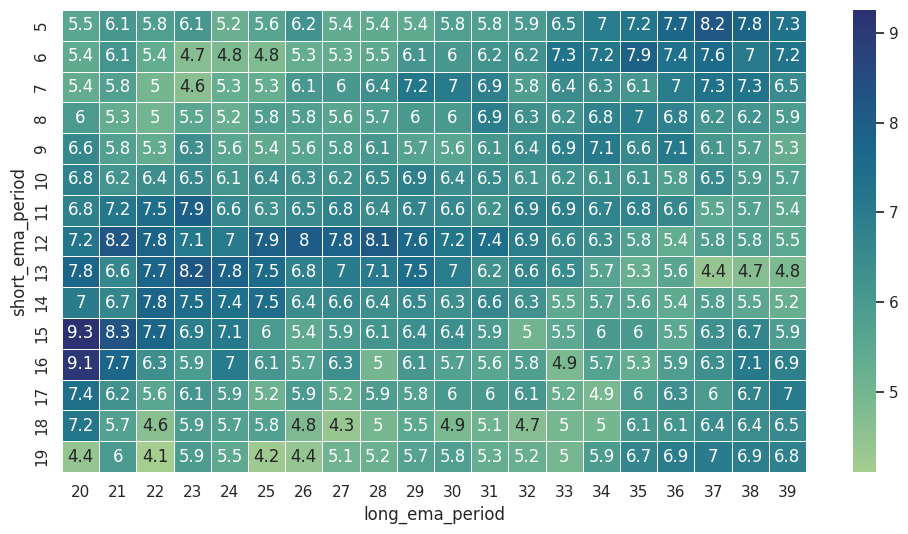

In [58]:
# Define the symbol and data
symbol = "SPY"
df = yf.download(symbol, start="2009-01-01", end="2024-01-01")

#Chart size
sns.set(rc={"figure.figsize":(12, 6)})

# Function to optimize
def optim_func(series):
    if series["Win Rate [%]"] < 70:
        return -1
    return series["Return (Ann.) [%]"]

# Strategy class
class EmaOscillator(Strategy):
    short_ema_period = 5
    long_ema_period = 5

    def init(self):
        self.short_ema = self.I(talib.SMA, self.data.Close, self.short_ema_period)
        self.long_ema = self.I(talib.SMA, self.data.Close, self.long_ema_period)

    def next(self):
        # If short EMA crosses below long EMA
        if crossover(self.short_ema, self.long_ema):
            self.position.close()
        elif crossover(self.long_ema, self.short_ema):
            self.buy()

# Backtest and optimize
bt = Backtest(df, EmaOscillator, cash=10000)

stats, heatmap = bt.optimize(
    short_ema_period=range(5, 20, 1),
    long_ema_period=range(20,40,1),
    maximize="Return (Ann.) [%]",
    return_heatmap = True,
)

print(stats)
print(f"Optimal short EMA period: {stats['_strategy'].short_ema_period}")
print(f"Optimal long EMA period: {stats['_strategy'].long_ema_period}")

# Example to print the optimal parameters for the first stock
#lower_bound = stats["_strategy"].short_ema_period
#print(stats["_strategy"])
#bt.plot()
#lower_bound = stats["_strategy"].lower_bound
print(heatmap)
hm = heatmap.groupby(["short_ema_period", "long_ema_period"]).mean().unstack()
print(hm)
print(stats)
#crearing heatmap
sns.heatmap(hm, cmap="crest", annot=True, linewidths=.5)
bt.plot()

short_ema_period  long_ema_period
5                 20                 5.542255
                  21                 6.050984
                  22                 5.780708
                  23                 6.087364
                  24                 5.210915
                                       ...   
19                35                 6.672671
                  36                 6.945606
                  37                 6.990549
                  38                 6.938031
                  39                 6.835949
Name: Return (Ann.) [%], Length: 300, dtype: float64


<Axes: xlabel='long_ema_period', ylabel='short_ema_period'>

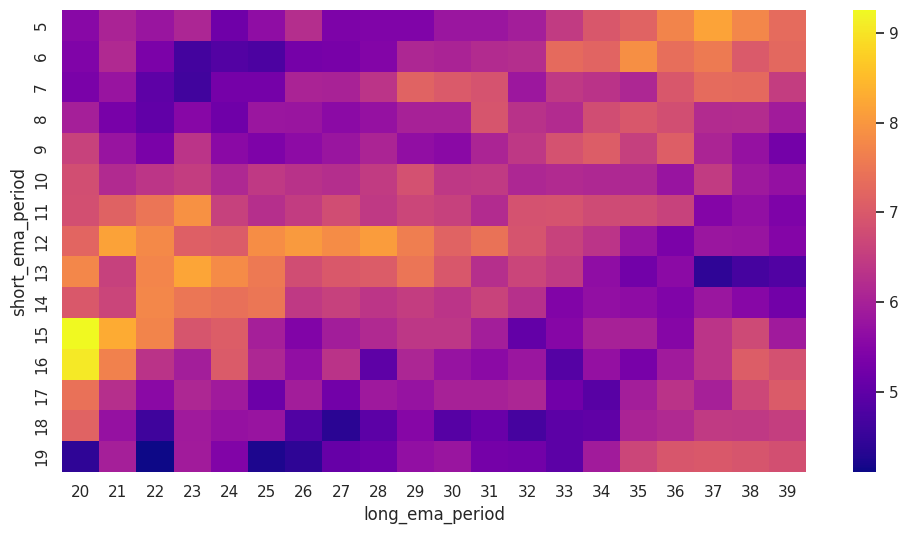

In [64]:
print(heatmap)
hm = heatmap.groupby(["short_ema_period", "long_ema_period"]).mean().unstack()
#print(hm)
#print(stats)
sns.heatmap(hm, cmap="plasma")
#bt.plot()

In [57]:
# Define the list of SP_100 stocks
sp_100 = [
    "AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "ALL", "AMGN", "AMT", "AMZN", 
    "AVGO", "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "C", 
    "CAT", "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CSCO", "CVS", "CVX", 
    "DHR", "DIS", "DUK", "EMR", "EXC", "F", "FDX", "GD", "GE", "GILD", 
    "GM", "GOOGL", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KHC", 
    "KO", "LIN", "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ", "MDT", "MET", 
    "META", "MMM", "MRK", "MS", "MSFT", "NEE", "NFLX", "NKE", "NVDA", "ORCL", 
    "PEP", "PFE", "PG", "PM", "PYPL", "QCOM", "RTX", "SBUX", "SCHW", "SO", 
    "SPGI", "T", "TGT", "TMO", "TMUS", "TSLA", "TXN", "UNH", "UNP", "UPS", 
    "V", "VZ", "WBA", "WFC", "WMT", "XOM"
]

# Function to optimize
def optim_func(series):
    if series["Win Rate [%]"] < 80:
        return -1
    return series["Sortino Ratio"]

# Strategy class
# Mean reversion trade ,if price is above long moving average it buys when it closes below short term EMA
class EmaOscillator(Strategy):
    short_ema_period = 20
    long_ema_period = 233

    def init(self):
        self.short_ema = self.I(talib.EMA, self.data.Close, self.short_ema_period)
        self.long_ema = self.I(talib.EMA, self.data.Close, self.long_ema_period)

    def next(self):
        if self.data.Close[-1] > self.long_ema[-1]:  # Price must be above the long-term EMA
            if crossover(self.data.Close, self.short_ema):
                self.position.close()
            elif crossover(self.short_ema, self.data.Close):
                self.buy()

# Function to run backtest for a single stock
def backtest_stock(symbol):
    df = yf.download(symbol, start="2009-01-01", end="2024-01-01")
    bt = Backtest(df, EmaOscillator, cash=10000)
    stats = bt.optimize(
        short_ema_period=range(5, 30, 1),
        maximize=optim_func
    )
    return stats

# Collect results for all stocks
results = []
optimal_params = []

for symbol in sp_100:
    print(f"Running backtest for {symbol}")
    result = backtest_stock(symbol)
    results.append(result)
    optimal_params.append(result['_strategy'].short_ema_period)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_optimal_params = pd.DataFrame(optimal_params, columns=['short_ema_period'])

# Calculate average optimal parameters
average_params = df_optimal_params.median(numeric_only=True)

# Calculate average statistics
average_stats = df_results.mean(numeric_only=True)

print("Average Optimal Parameters for SPY100:")
print(f"Median short EMA period: {average_params['short_ema_period']}")

print("Average Statistics for SPY100 30:")
print(average_stats)

# Optional: Print the optimal parameters for each stock
for symbol, stats in zip(sp_100, results):
    print(f"{symbol}: Optimal short EMA period: {stats['_strategy'].short_ema_period}")


Running backtest for AAPL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ABBV
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ABT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ACN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ADBE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AIG
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ALL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AMGN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AMT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AMZN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AVGO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for AXP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BAC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BKNG
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BLK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for BMY
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for C
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CAT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CHTR
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CMCSA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for COF
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for COP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for COST
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CSCO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CVS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for CVX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for DHR
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for DIS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for DUK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for EMR
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for EXC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for F
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for FDX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GILD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GOOGL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for GS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for HD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for HON
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for IBM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for INTC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for JNJ
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for JPM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for KHC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for KO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LIN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LLY
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LMT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for LOW
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MCD
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MDLZ
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MDT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MET
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for META
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MMM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MRK
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for MSFT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NEE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NFLX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NKE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for NVDA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for ORCL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PEP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PFE
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PG
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for PYPL
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for QCOM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for RTX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SBUX
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SCHW
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for SPGI
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for T
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TGT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TMO
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TMUS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TSLA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for TXN
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for UNH
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for UNP
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for UPS
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for V
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for VZ
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for WBA
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for WFC
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for WMT
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Running backtest for XOM
[*********************100%***********************]  1 of 1 completed


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Average Optimal Parameters for SPY100:
Median short EMA period: 5.0
Average Statistics for SPY100 30:
Exposure Time [%]           52.687706
Equity Final [$]         34962.259344
Equity Peak [$]          40352.394952
Return [%]                 249.622593
Buy & Hold Return [%]     1225.275635
Return (Ann.) [%]            7.094865
Volatility (Ann.) [%]       21.460940
Sharpe Ratio                 0.344900
Sortino Ratio                0.565080
Calmar Ratio                 0.202854
Max. Drawdown [%]          -43.312496
Avg. Drawdown [%]           -4.199222
# Trades                   275.957895
Win Rate [%]                69.781624
Best Trade [%]              11.835306
Worst Trade [%]            -20.333306
Avg. Trade [%]               0.411117
Profit Factor                1.933235
Expectancy [%]               0.466315
SQN                          2.121986
dtype: float64
AAPL: Optimal short EMA period: 5
ABBV: Optimal short EMA period: 22
ABT: Optimal short EMA period: 25
ACN: Optimal short E